In [1]:
# Step 1: Import Required Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight

In [2]:
data_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
val_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation'
classes = os.listdir(data_dir)


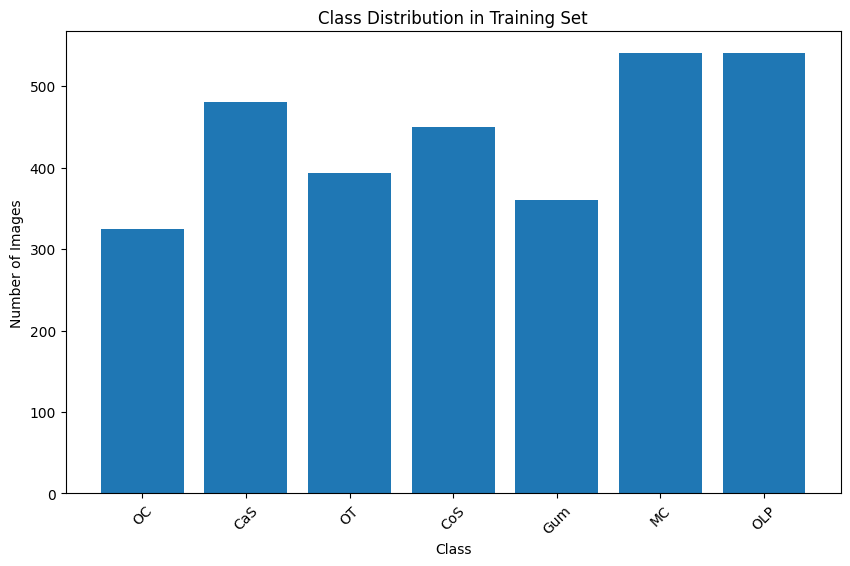

In [3]:
class_counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [4]:
# Step 3: Data Preprocessing and Augmentation
# Constants
IMG_SIZE = (256, 256)  # Resize images to 256x256
BATCH_SIZE = 32
EPOCHS = 50

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0,  # Black padding for dental images
    validation_split=0.2
)

# Validation data (only normalization)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


Found 3087 images belonging to 7 classes.


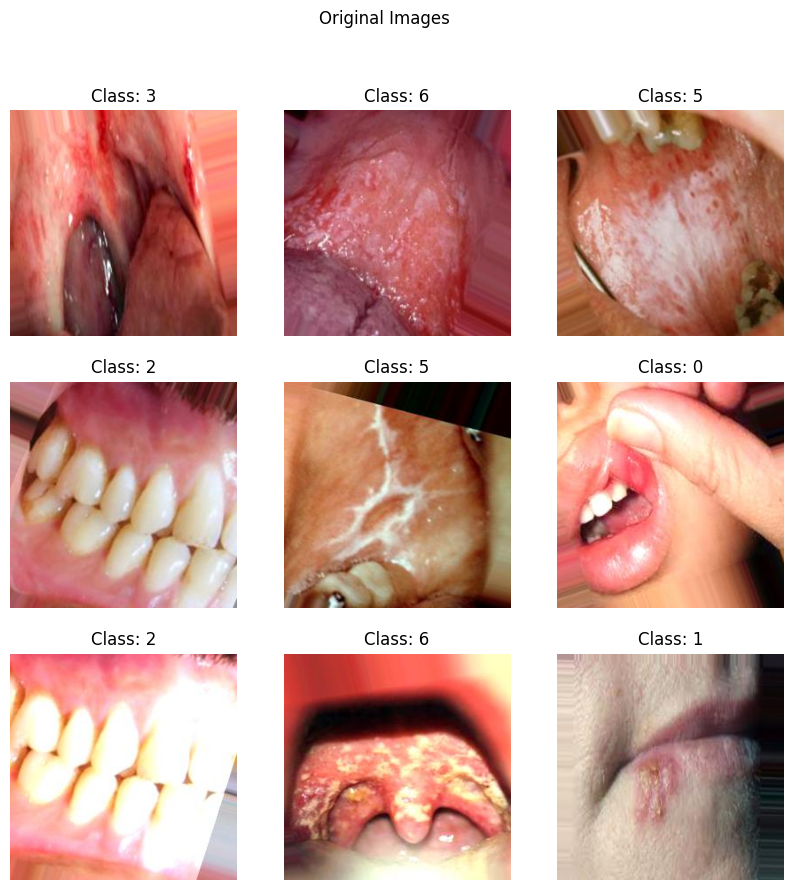

Found 3087 images belonging to 7 classes.


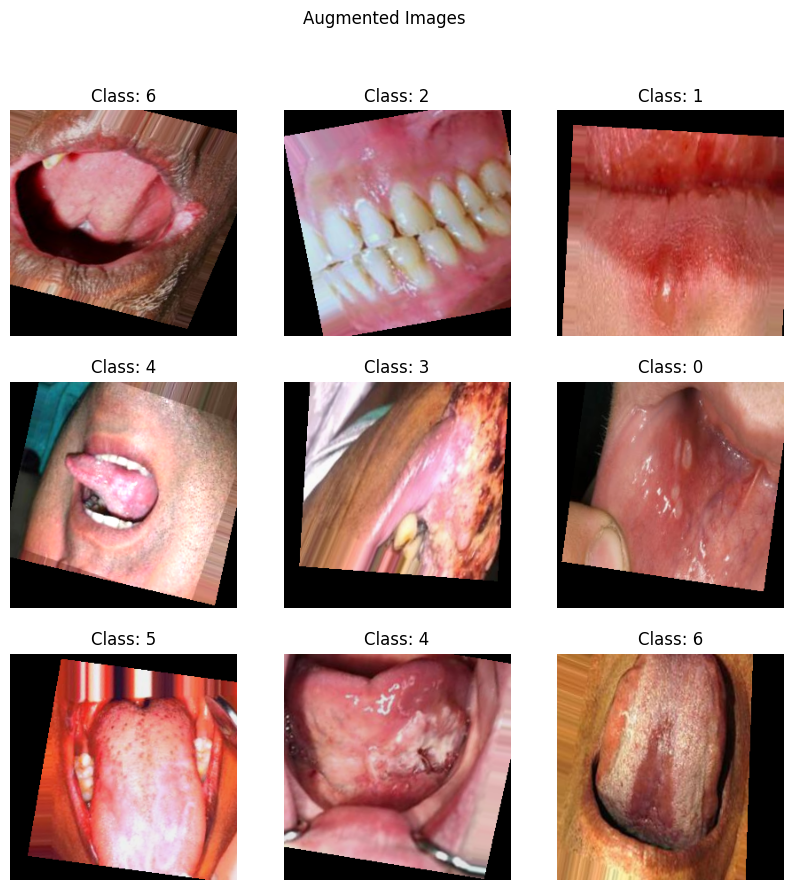

In [5]:
# Step 4: Visualize Augmented Images
def plot_augmented_images(generator, title):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize original images
original_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(data_dir, batch_size=BATCH_SIZE)
plot_augmented_images(original_generator, 'Original Images')

# Visualize augmented images
augmented_generator = train_datagen.flow_from_directory(data_dir, batch_size=BATCH_SIZE)
plot_augmented_images(augmented_generator, 'Augmented Images')

In [6]:
# Step 5: Build InceptionV3 Model from Scratch
def build_densenet_model(input_shape=(256, 256, 3), num_classes=7):
    # Use InceptionV3 architecture with pre-trained weights
    base_model = InceptionV3(
        include_top=False,
        weights='imagenet',  
        input_shape=input_shape
    )
    base_model.trainable = False
    
    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Compile the model
model = build_densenet_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 127, 127, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 127, 127, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 125, 125, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 125, 125, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 125, 125, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 62, 62, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 62, 62, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 62, 62, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,863,655 (87.22 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [7]:
# Step 6: Class Weight Calculation (if dataset is imbalanced)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [8]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 837ms/step - accuracy: 0.2838 - loss: 2.2772 - val_accuracy: 0.4980 - val_loss: 1.3845
Epoch 2/50
 1/96 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.4062 - loss: 1.8254

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.4062 - loss: 1.8254 - val_accuracy: 0.5000 - val_loss: 1.5194
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 467ms/step - accuracy: 0.4884 - loss: 1.4809 - val_accuracy: 0.6025 - val_loss: 1.1007
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4000 - loss: 1.6451 - val_accuracy: 0.5000 - val_loss: 1.4025
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 471ms/step - accuracy: 0.5532 - loss: 1.2440 - val_accuracy: 0.6572 - val_loss: 0.9307
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6250 - loss: 1.1496 - val_accuracy: 0.7500 - val_loss: 0.7570
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 480ms/step - accuracy: 0.6078 - loss: 1.1212 - val_accuracy: 0.7090 - val_loss: 0.8158
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.6250 - loss: 1.1590 - val_accuracy: 0.7500 - val_loss: 0.4451
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 477ms/step - accuracy: 0.6376 - loss: 1.0129 - val_accuracy: 0.7285 - v

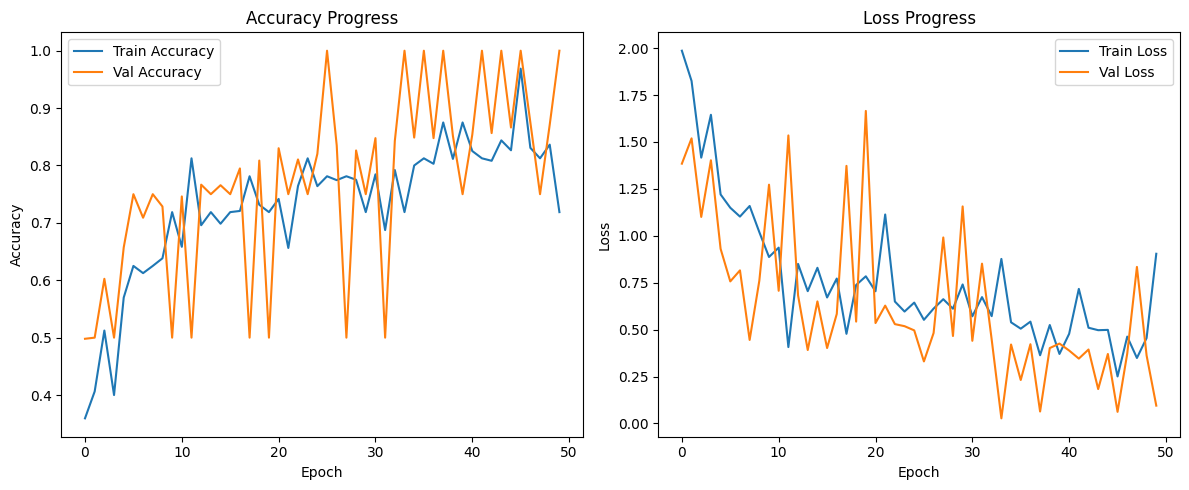

In [9]:
# Step 8: Evaluate Training Progress
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Found 1028 images belonging to 7 classes.
 1/33 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.8438 - loss: 0.3436

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.8939 - loss: 0.3003

Test Accuracy: 86.67%
Test Loss: 0.3882
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step

Classification Report:
              precision    recall  f1-score   support

         CaS       0.89      0.89      0.89       160
         CoS       0.95      0.95      0.95       149
         Gum       0.81      0.94      0.87       120
          MC       0.89      0.81      0.85       180
          OC       0.77      0.92      0.84       108
         OLP       0.91      0.76      0.83       180
          OT       0.83      0.85      0.84       131

    accuracy                           0.87      1028
   macro avg       0.86      0.88      0.87      1028
weighted avg       0.87      0.87      0.87      1028



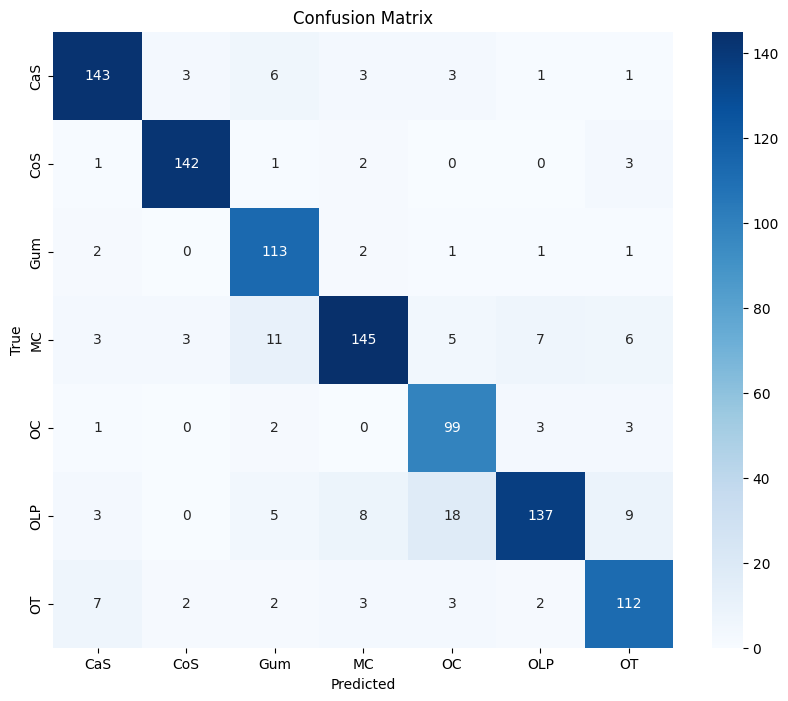

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Path to test dataset
test_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing'

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False ,  # Important for correct label order
    classes=["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
)

# Evaluate model on test set
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# Visualize sample predictions
def visualize_predictions(num_samples=9):
    images, labels = next(test_generator)
    preds = model.predict(images)
    
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        true_label = class_labels[np.argmax(labels[i])]
        pred_label = class_labels[np.argmax(preds[i])]
        prob = np.max(preds[i])
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label} ({prob:.2f})", color=color)
        plt.axis('off')
    plt.savefig('/kaggle/working/sample_predictions.png')
    plt.show()


In [ ]:
model.save('/kaggle/working/teeth_classification_model.h5')

In [11]:
pip install streamlit tensorflow pillow matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 89.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
!pip install -q watchdog  # Needed for Streamlit

In [31]:
%%writefile app.py

# app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Set page config
st.set_page_config(
    page_title="Dental Teeth Classifier",
    page_icon="🦷",
    layout="wide"
)

# Custom CSS
st.markdown("""
<style>
    .reportview-container {
        background: #f0f2f6;
    }
    .sidebar .sidebar-content {
        background: #ffffff;
    }
    h1 {
        color: #2c3e50;
    }
    .prediction {
        font-size: 20px !important;
        color: #2ecc71 !important;
        font-weight: bold !important;
    }
</style>
""", unsafe_allow_html=True)

# Load model
@st.cache_resource
def load_model():
    return tf.keras.models.load_model('/kaggle/input/your-dataset-name/teeth_classification_model.h5')

model = load_model()

# Class labels (update with your actual class names)
class_names = [
    'CaS', 
    'CoS', 
    'Gum', 
    'MC',
    'OC',
    'OLP',
    'OT'
]

# Image preprocessing
def preprocess_image(image):
    img = image.resize((256, 256))
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Main app
def main():
    st.title("🦷 AI Dental Teeth Classification")
    st.markdown("Upload a dental image for automatic classification into 7 categories")

    # Sidebar
    st.sidebar.header("About")
    st.sidebar.markdown("""
    This AI model classifies dental images into 7 categories:
    - CaS
    - CoS
    - Gum
    - MC
    - OC
    - OLP
    - OT
    """)

    # File upload
    uploaded_file = st.file_uploader(
        "Choose a dental image...",
        type="jpg"
    )

    if uploaded_file is not None:
        # Display original image
        col1, col2 = st.columns(2)
        
        with col1:
            st.subheader("Original Image")
            image = Image.open(uploaded_file).convert('RGB')
            st.image(image, use_column_width=True)

        # Preprocess and predict
        with st.spinner('Analyzing the dental image...'):
            processed_image = preprocess_image(image)
            predictions = model.predict(processed_image)
            predicted_class = np.argmax(predictions)
            confidence = np.max(predictions) * 100

        # Display results
        with col2:
            st.subheader("Analysis Results")
            
            # Prediction and confidence
            st.markdown(f"""
            <div class="prediction">
                Predicted: {class_names[predicted_class]}<br>
                Confidence: {confidence:.2f}%
            </div>
            """, unsafe_allow_html=True)

            # Confidence visualization
            st.markdown("### Class Confidence Distribution")
            fig, ax = plt.subplots()
            ax.barh(class_names, predictions[0] * 100)
            ax.set_xlabel('Confidence (%)')
            ax.set_title('Prediction Confidence')
            st.pyplot(fig)

            # Image processing visualization
            st.markdown("### Processed Image (Model Input)")
            fig2, ax2 = plt.subplots()
            ax2.imshow(processed_image[0])
            ax2.axis('off')
            st.pyplot(fig2)

if __name__ == "__main__":
    main()

Overwriting app.py


In [32]:
!pip install -q --upgrade protobuf

In [33]:
!streamlit run app.py --server.port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://34.32.130.190:8501

^C
  Stopping...


In [16]:
!pip install -q pyngrok

In [21]:
import threading
import os
from pyngrok import ngrok

# Set up the port number
port = 8501

# Run Streamlit app in a separate thread
def run_streamlit():
    os.system(f'streamlit run app.py --server.port {port} --server.headless true')

thread = threading.Thread(target=run_streamlit)
thread.start()

# Expose the app via ngrok
public_url = ngrok.connect(port).public_url
print(f"Access the Streamlit app here: {public_url}")

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.